# Unsupervised Learning

By Spencer Cheung, Phuc Nguyen, Joey Higgins

### TODO

- PCA (PN) (visual)

- trade flow : heatmap (PN) (visual)

- K-means clustering (JH) (visual)

- 

In [1]:
import country_converter as coco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import yfinance as yf

In [2]:
cc = coco.CountryConverter()
p = re.compile(r",\s*(?:Kingdom of the Netherlands|United Kingdom-British Overseas Territory|Republic of the|Union of the|State of the)$",
    re.I)

def clean(country):
    if pd.isna(country): 
        return country
    country = str(country).strip()
    country = p.sub("", country)
    return re.sub(r",\s*The$", "", country, flags=re.I)

def short(country):
    if pd.isna(country):
        return pd.NA
    res = cc.convert(names=clean(country), to="name_short")
    if isinstance(res, (list, tuple)):
        res = res[0] if res else pd.NA
    if not res or res == "not found" or pd.isna(res):
        warnings.warn(f"Problem: {country}")
        return pd.NA
    return res

In [3]:
EUR = ["Austria","Belgium","Cyprus","Estonia","Finland","France","Germany","Greece","Ireland",
        "Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Portugal","Slovakia",
        "Slovenia","Spain","Andorra","Monaco","San Marino","Vatican City","Saint Barthélemy",
        "Saint Pierre and Miquelon","Kosovo","Montenegro","Bosnia and Herzegovina","Bulgaria",
        "Cape Verde","Cameroon","Central African Republic","Chad","Republic of the Congo","Equatorial Guinea",
        "Gabon","Benin","Burkina Faso","Côte d'Ivoire","Guinea-Bissau","Mali","Niger","Senegal","Togo",
        "French Polynesia","New Caledonia","Wallis and Futuna","Comoros","Croatia","Morocco",
        "São Tomé and Príncipe","Denmark","North Macedonia"]

GBP = ["Guernsey","Jersey","Isle of Man","Gibraltar","Falkland Islands","Saint Helena"]

other = ["Bhutan","Nepal","North Korea","Afghanistan","Turkmenistan","South Sudan","Guam",
        "Macau", "Tuvalu", "Kiribati","Palau","Greenland","Maldives","Iraq","Solomon Islands",
        "Brunei Darussalam","Bangladesh","Myanmar","Marshall Islands","Iran", "Yemen", "Libya","Somalia",
        "Liberia","Sudan","Sierra Leone","Mongolia","Angola","Kyrgyz Republic","Tajikistan"]

EUR   = {short(x) for x in EUR if pd.notna(short(x))}
GBP   = {short(x) for x in GBP if pd.notna(short(x))}
other = {short(x) for x in other if pd.notna(short(x))}

In [4]:
df_trade = pd.read_parquet("trade_cleaned.parquet")
df_gdp = pd.read_parquet("GDP_cleaned.parquet")
df_trade['TRADE_FLOW'].unique()
df_trade[df_trade["COUNTRY"]=="Russia"]

,COUNTRY,COUNTERPART_COUNTRY,TIME_PERIOD,OBS_VALUE,TRADE_FLOW,UNIT
53167,Russia,Mauritius,2016-Q1,562500.0,Exports of goods,US dollar
53168,Russia,Mauritius,2016-Q2,547673.0,Exports of goods,US dollar
53169,Russia,Mauritius,2016-Q3,1723433.0,Exports of goods,US dollar
53170,Russia,Mauritius,2016-Q4,3342655.0,Exports of goods,US dollar
53171,Russia,Mauritius,2017-Q1,1459324.0,Exports of goods,US dollar
...,...,...,...,...,...,...
1029982,Russia,Tonga,None,NaN,None,None
1030121,Russia,Tuvalu,None,NaN,None,None
1030151,Russia,Timor-Leste,None,NaN,None,None
1030443,Russia,Samoa,None,NaN,None,None


In [5]:
df_trade.head()

,COUNTRY,COUNTERPART_COUNTRY,TIME_PERIOD,OBS_VALUE,TRADE_FLOW,UNIT
0,Suriname,Senegal,2021-Q1,3146.0,Exports of goods,US dollar
1,Suriname,Senegal,2021-Q2,1737.0,Exports of goods,US dollar
2,Suriname,Senegal,2021-Q3,49752.0,Exports of goods,US dollar
3,Suriname,Senegal,2021-Q4,187.0,Exports of goods,US dollar
4,Suriname,Senegal,2022-Q2,9474.0,Exports of goods,US dollar


In [6]:
#Anchors selection
df_gdp = df_gdp[~(df_gdp['COUNTRY'] == "United States")]
df_gdp.head()
Anchor = {"EUR": EUR,
    "CNY": {"China"},
    "JPY": {"Japan"},}

# No USD due to many relationship ties with multiple currency.

period = 10     #time period
n = 10          #n neighbor            
v = 0.05       #minimum percentage volume

#Exports of goods
#neighbor mapping
neighbor = {x: i for i, y in Anchor.items() for x in y}

ex = EUR | GBP | other | {"China","Japan","United States"}

df_trade = df_trade.dropna(subset=["COUNTRY", "COUNTERPART_COUNTRY", "TIME_PERIOD", "OBS_VALUE"]).copy()

#Keep data period
df_trade = df_trade[df_trade["TIME_PERIOD"].astype(str).str.match(r"^\d{4}")]
df_trade["year"] = df_trade["TIME_PERIOD"].astype(str).str[:4].astype(int)
max_year = int(df_trade["year"].max())
df_trade = df_trade[df_trade["year"].between(max_year - period + 1, max_year)]

#Filter and map potential neighbors
df_export = df_trade[~df_trade["COUNTRY"].isin(ex)].copy()
df_export["anchor"] = df_export["COUNTERPART_COUNTRY"].map(neighbor)

#Total exports per country
etot = (df_export.groupby("COUNTRY", as_index=False)["OBS_VALUE"].sum()
        .rename(columns={"OBS_VALUE": "export_total"}))

#Exports to each anchor
eanch = (df_export.dropna(subset=["anchor"]).groupby(["COUNTRY", "anchor"], as_index=False)["OBS_VALUE"].sum()
        .rename(columns={"OBS_VALUE": "export_to_anchor"}))

#Export shares
esh = (eanch.merge(etot, on="COUNTRY", how="left")
        .assign(export_share=lambda d: d["export_to_anchor"]/d["export_total"]))

#Best export anchor per country
bexp = (esh.sort_values(["COUNTRY", "export_share", "export_to_anchor"],ascending=[True, False, False])
        .drop_duplicates("COUNTRY"))
bexp = bexp[bexp["export_share"]>=v]

#Swap role
df_import = (df_trade.rename(columns={"COUNTRY": "COUNTERPART_COUNTRY_orig", "COUNTERPART_COUNTRY": "COUNTRY"})
             .rename(columns={"COUNTERPART_COUNTRY_orig": "COUNTERPART_COUNTRY"}))

#Potential neighbors
df_import = df_import[~df_import["COUNTRY"].isin(ex)].copy()
df_import["anchor"] = df_import["COUNTERPART_COUNTRY"].map(neighbor)

#Total imports per country
import_totals = (df_import.groupby("COUNTRY", as_index=False)["OBS_VALUE"].sum()
                .rename(columns={"OBS_VALUE": "import_total"}))

#Imports from each anchor
ianch = (df_import.dropna(subset=["anchor"])
        .groupby(["COUNTRY", "anchor"],as_index=False)["OBS_VALUE"].sum()
        .rename(columns={"OBS_VALUE": "import_from_anchor"}))

#Import shares
ish = (ianch.merge(import_totals, on="COUNTRY", how="left")
        .assign(import_share=lambda d: d["import_from_anchor"] / d["import_total"]))

#Best import anchor per country
bimp = (ish.sort_values(["COUNTRY", "import_share", "import_from_anchor"],ascending=[True, False, False])
        .drop_duplicates("COUNTRY"))
bimp = bimp[bimp["import_share"] >= v]

In [7]:
#Combine table
comb = (esh.merge(ish,on=["COUNTRY", "anchor"],how="outer",suffixes=("_exp", "_imp")))

#Handle missing value
f = ["export_to_anchor", "export_total", "export_share",
                "import_from_anchor", "import_total", "import_share"]
for c in f:
    if c not in comb.columns:
        comb[c] = 0.0
comb[f] = comb[f].fillna(0.0)

#Combined metrics
comb = (comb.assign(total_trade_with_anchor=lambda d: d["export_to_anchor"] + d["import_from_anchor"],
        total_trade_volume=lambda d: d["export_total"] + d["import_total"]))
comb["combined_exposure"] = 0.0
nz = comb["total_trade_volume"] > 0
comb.loc[nz, "combined_exposure"] = (comb.loc[nz, "total_trade_with_anchor"]/comb.loc[nz, "total_trade_volume"])
comb_f = comb.loc[comb["combined_exposure"] >= v].copy()

#Rank neighbors per anchor
comb_f = comb_f.sort_values(by=["anchor","combined_exposure","total_trade_with_anchor","export_share",
        "import_share","COUNTRY"],ascending=[True, False, False, False, False, True])

#Rank within each anchor and take top n
comb_f["rank_within_anchor"] = comb_f.groupby("anchor")["combined_exposure"].rank(method="first", ascending=False)
comb_top = comb_f.loc[comb_f["rank_within_anchor"] <= n].copy()

#Final neighbor
neighbors_dict = (comb_top.groupby("anchor")["COUNTRY"].apply(list).to_dict())

#Summary results
summary = (comb_top[["anchor", "COUNTRY","combined_exposure","export_share", "import_share",
        "export_to_anchor", "import_from_anchor","export_total", "import_total",
        "total_trade_with_anchor", "total_trade_volume","rank_within_anchor"]]
        .sort_values(["anchor", "rank_within_anchor"]).reset_index(drop=True))

res = summary.copy()
for col in ["combined_exposure", "export_share", "import_share"]:
    res[col] = (res[col] * 100).round(2)

res_sorted = res.sort_values(["anchor", "rank_within_anchor"])

anchor_neighbor = (res_sorted.groupby("anchor")["COUNTRY"].apply(list).to_dict())

'''#anchor_neighbor["CNY"].remove("Tanzania")
anchor_neighbor["CNY"].remove("Australia")
anchor_neighbor["JPY"].remove("Philippines")
anchor_neighbor["JPY"].remove("Vietnam")
'''

for a, c in [("CNY","Australia"), ("JPY","Philippines"), ("JPY","Vietnam")]:
    if a in anchor_neighbor and c in anchor_neighbor[a]:
        anchor_neighbor[a].remove(c)
        
anchor_neighbor

{'CNY': ['DR Congo',
  'Laos',
  'Tanzania',
  'Chile',
  'Guinea',
  'Pakistan',
  'Philippines',
  'Vietnam',
  'Mauritania'],
 'EUR': ['Albania',
  'Czechia',
  'Tunisia',
  'Romania',
  'Hungary',
  'Poland',
  'Serbia',
  'Sweden',
  'Iceland',
  'Algeria'],
 'JPY': ['Papua New Guinea',
  'Taiwan',
  'Thailand',
  'Australia',
  'Indonesia',
  'South Korea',
  'Malaysia',
  'New Zealand']}

In [8]:
# Draft, please correct for mistakes!

# creating feature, it will be based on the combined data.
# trying pivot table
features = summary.pivot_table(
    index = 'COUNTRY',
    columns = 'anchor',
    values = 'combined_exposure',
    aggfunc = 'sum',
    fill_value = 0.0
)

# adding a scaler.
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [9]:
# Un-supervise
#PCA https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

# array([0.35579744, 0.31791882])

# put this into a dataframe, if we are plotting
pca_df = pd.DataFrame(X_pca, index = features.index, columns = ['PC1', 'PC2'])
#pca_df

In [10]:
# try K means
#KMean https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
k = 3
km = KMeans(n_clusters = k, random_state = 42)

clusters = km.fit_predict(X)

In [11]:
# test pca_df with clusters
pca_df['cluster'] = clusters
pca_df

,PC1,PC2,cluster
COUNTRY,,,
Albania,-1.804929,0.020297,1
Algeria,-1.389717,0.013622,1
Australia,1.819678,-0.222685,2
Chile,0.810867,1.275496,0
Czechia,-1.777495,0.019856,1
DR Congo,1.521384,2.254315,0
Guinea,0.807653,1.271068,0
Hungary,-1.687538,0.018410,1
Iceland,-1.478339,0.015047,1


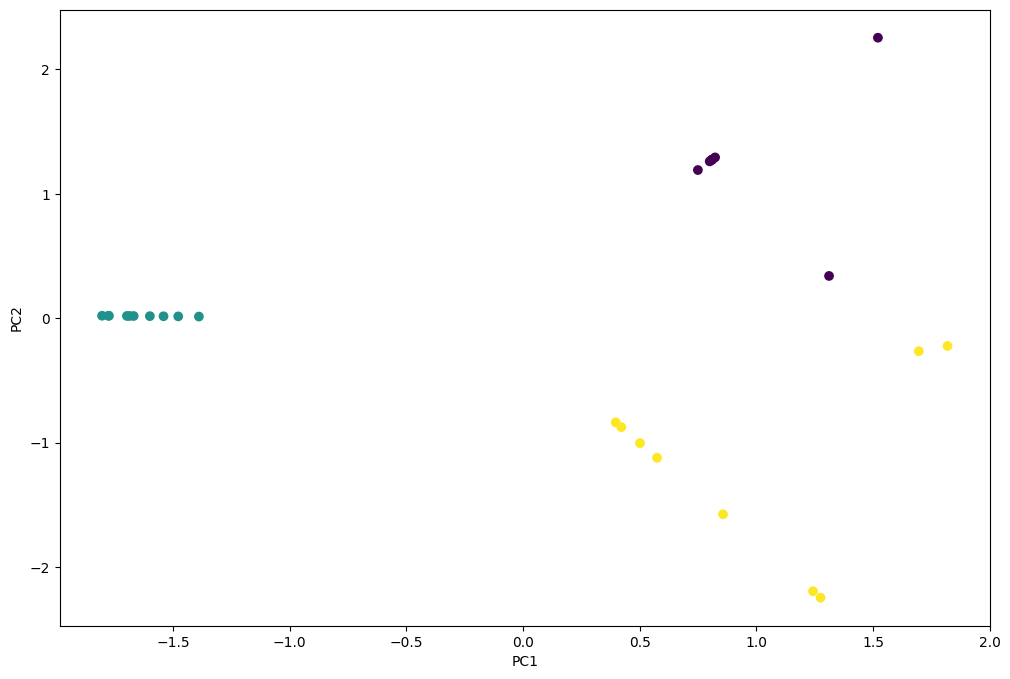

In [12]:
plt.figure(figsize = (12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = pca_df['cluster'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [13]:
# Overall
    # We're determining the total daily return over ten years, not the end return
    # We're doing this because that allows us to test for "stationary"
    # Example of output
        # Predicting the return per day of the Nepalese Rupee, given the return per day of the Indian Rupee
        # Based on 10 years of foreign exchange rates (from YFinance)
        # Given the Nepalese Rupee went from 3 to 3.5 in one day, and the Indian Rupee went from 4 to 5

# Determine anchor/neighbor pairings (PN)
    # Top 3 anchors and their top 3 neighbors

# USE PCA FX Rates (SC) - Unsupervised

# Use XGBoost to present a baseline model to try and beat (JH) - Supervised
    # Compare XGBoost model of just our neighbor price movements by itself - control
    # Compare XGBoost model of our neighbor and our anchor - test

# Use Granger Causality to determine causality (PN) - Causality

# If time allows
    # Increase the nubmer of neighbors
    # Maybe   
        # Use VAR if time allows
        # Use ARIMA if time allows
    # Confirm with network analysis on the currency (JH)
        # Return back to this to confirm Phuc's descriptive analysis for neighbors/anchors
        # Scope down to just the anchors

In [14]:
#Anchor-Neighbors list:
old_anch_neighbor = {"CNY": ["Mongolia","DR Congo","Kyrgyz Republic","Solomon Islands","Macau",
                    "Angola","Myanmar","Pakistan","Vietnam","Tanzania",],
    "EUR": ["Greenland","Libya","Albania","Switzerland","Faroe Islands","Tunisia","Czechia","Sweden","Romania","Hungary",],
    "INR": ["Sri Lanka","Guinea","Tanzania","Mozambique","Bolivia",],
    "JPY": ["Kiribati","Papua New Guinea","Brunei Darussalam","Philippines",],}


In [15]:
# test yahoo finance yf. install yf in notebook
# we identify the hour anchor: Anchor = {"EUR": EUR, "CNY": {"China"}, "JPY": {"Japan"}, "INR": {"India"}}

# going to start by pulling Anchor Countries
# codes are obtain from yahoo finance symbol
# https://finance.yahoo.com/markets/currencies/

fx_list = {
    #"EUR" : "EURUSD=X", # this ons is EUR/USD
    "EUR" : "EUR=X", # this ons is USD/EUR
    "CNY" : "CNY=X", # this one is USD/CNY
    "JPY" : "JPY=X", # This one is USD/JPY
    "INR" : "INR=X", # This one is USD/INR
    
    # Manually added by JH
    "AUD" : "AUD=X", # This one is AUD
    "CAD" : "CAD=X", # This one is CAD
    "NOK" : "NOK=X", # This one is NOK
    "MXN" : "MXN=X", # This one is MXN
    "BRL" : "BRL=X", # This one is BRL
    "ZAR" : "ZAR=X", # This one is ZAR
    "TRY" : "TRY=X", # This one is TRY
    "CLP" : "CLP=X", # This one is CLP
    "COP" : "COP=X", # This one is COP
    "ILS" : "ILS=X", # This one is ILS

    "MNT" : "MNT=X", # This one is USD/Mongolia
    #"SDG" : "SDG=X", # This one is USD/SSudan (Phuc: Remove)
    #"TMT" : "TMT=X", # This one is USD/Turk (Phuc: Remove)
    #"KPW" : "KPW=X", # This one is USD/North Korea W (Phuc: Remove)
    "CDF" : "CDF=X", # This one is USD/Congo 
    "SBD" : "SBD=X", # This one is USD/Solomon Island 
    "AOA" : "AOA=X", # This one is USD/Angola 
    "MOP" : "MOP=X", # This one is USD/Macau 
    "AUD" : "AUD=X", # This one is USD/Australia 
    "CLP" : "CLP=X", # This one is USD/Chile
    #Phuc: add
    "KGS": "KGS=X",  # USD/KGS (Kyrgyz Republic)
    "MMK": "MMK=X",  # USD/MMK (Myanmar)
    "PKR": "PKR=X",  # USD/PKR (Pakistan)
    "VND": "VND=X",  # USD/VND (Vietnam)

    "DKK" : "DKK=X", # This one is USD/Greenland
    "ALL" : "ALL=X", # This one is USD/Albania
    "TND" : "TND=X", # This one is USD/tunisia
    "CZK" : "CZK=X", # This one is USD/Czechia
    "LYD" : "LYD=X", # This one is USD/Libya
    "HUF" : "HUF=X", # This one is USD/Hungary
    "RON" : "RON=X", # This one is USD/Romania
    "PLN" : "PLN=X", # This one is USD/Poland
    "ISK" : "ISK=X", # This one is USD/Iceland 
    "DZD" : "DZD=X", # This one is USD/Algeria

    #"BTN" : "INR=X", # This one is Bhutan/USD peg to INR 1:1 ratio (Phuc: remove)
    "NPR" : "NPR=X", # This one is USD/Nepal
    #"AFN" : "AFN=X", # This one is USD/afghanistan (Phuc: remove)
    "GNF" : "GNF=X", # This one is USD/Guinea
    "TZS" : "TZS=X", # This one is USD/Tanzania
    "MZN" : "MZN=X", # This one is USD/Mozambique
    "BOB" : "BOB=X", # This one is USD/Bolivia
    #Phuc: add
    "CHF": "CHF=X",  # USD/CHF (Switzerland)
    "SEK": "SEK=X",  # USD/SEK (Sweden)

    #"KIR" : "AUD=X", # This one is USD/Kir tied to AUD 1:1 ratio (Phuc: remove)
    "PGK" : "PGK=X", # This one is USD/Papua New Guinea
    "BND" : "BND=X", # This one is USD/Brunei Darussalam
    "PHP" : "PHP=X", # This one is USD/INR
    #Phuc: add
    "LKR" : "LKR=X",  # USD/LKR (Sri Lanka)

}

# period is the timeframe we want, we conclude for the time being, it will be 10 years
PERIOD = "10y"

# we conclude we will be looking at exchanges on a daily basis.
INTERVAL = "1d"
FFill_Limit = 3
N_PCS_To_Cluster = 3
N_Cluster = 3

tickers = list(fx_list.values())

# https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download
# guys, im going to test this function see if it does what we need, please correct as needed

#yfinance.download(tickers, start=None, end=None, actions=False, 
#threads=True, ignore_tz=None, group_by='column', auto_adjust=None, 
#back_adjust=False, repair=False, keepna=False, progress=True, period=None, 
#interval='1d', prepost=False, proxy=<object object>, rounding=False, timeout=10, 
#session=None, multi_level_index=True)

yfinance_fx_raw = yf.download(
    tickers, 
    period=PERIOD,
    interval = INTERVAL,
    auto_adjust=None,
    progress= False
)

/tmp/ipykernel_695/3806275242.py:94: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yfinance_fx_raw = yf.download(


In [16]:
#yfinance_fx_raw
# Spencer Up to this point agree with above
# will do a full review on below Phuc's PCA.

# PHUC'S PCA

In [17]:
# test yahoo finance yf. install yf in notebook
# we identify the hour anchor: Anchor = {"EUR": EUR, "CNY": {"China"}, "JPY": {"Japan"}}

# going to start by pulling Anchor Countries
# codes are obtain from yahoo finance symbol
# https://finance.yahoo.com/markets/currencies/

fx_list = {
    # Anchor currencies
    "CNY": "CNY=X",  # China
    "EUR": "EUR=X",  # Euro
    "JPY": "JPY=X",  # Japan

    # Neutral currencies
    "CAD": "CAD=X",  # Canada
    "BRL": "BRL=X",  # Brazil
    "MXN": "MXN=X",  # Mexico
    "COP": "COP=X",  # Colombia
    "PEN": "PEN=X",  # Peru
    "NOK": "NOK=X",  # Norway
    "ZAR": "ZAR=X",  # South Africa
    "INR": "INR=X",  # India
    "TRY": "TRY=X",  # Turkey
    "EGP": "EGP=X",  # Egypt
    "RUB": "RUB=X",  # Russia
    "ILS": "ILS=X",  # Israel

    # CNY group
    "CDF": "CDF=X",  # DR Congo
    "LAK": "LAK=X",  # Laos
    "TZS": "TZS=X",  # Tanzania
    "CLP": "CLP=X",  # Chile
    "GNF": "GNF=X",  # Guinea
    "PKR": "PKR=X",  # Pakistan
    "PHP": "PHP=X",  # Philippines
    "VND": "VND=X",  # Vietnam
    "MRU": "MRU=X",  # Mauritania

    # EUR group
    "ALL": "ALL=X",  # Albania
    "CZK": "CZK=X",  # Czechia
    "TND": "TND=X",  # Tunisia
    "RON": "RON=X",  # Romania
    "HUF": "HUF=X",  # Hungary
    "PLN": "PLN=X",  # Poland
    "RSD": "RSD=X",  # Serbia
    "SEK": "SEK=X",  # Sweden
    "ISK": "ISK=X",  # Iceland
    "DZD": "DZD=X",  # Algeria

    # JPY group
    "PGK": "PGK=X",  # Papua New Guinea
    "TWD": "TWD=X",  # Taiwan
    "THB": "THB=X",  # Thailand
    "AUD": "AUD=X",  # Australia
    "IDR": "IDR=X",  # Indonesia
    "KRW": "KRW=X",  # South Korea
    "MYR": "MYR=X",  # Malaysia
    "NZD": "NZD=X",  # New Zealand
}

# period is the timeframe we want, we conclude for the time being, it will be 10 years
PERIOD = "10y"

# we conclude we will be looking at exchanges on a daily basis.
INTERVAL = "1d"
FFill_Limit = 3
N_PCS_To_Cluster = 3
N_Cluster = 3

tickers = list(fx_list.values())

yfinance_fx_raw = yf.download(
    tickers, 
    period=PERIOD,
    interval = INTERVAL,
    auto_adjust=None,
    progress= False
)

/tmp/ipykernel_695/524235298.py:73: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yfinance_fx_raw = yf.download(


In [18]:
#remove problem currency
x = yfinance_fx_raw['Close']
c = x.notna().sum().sort_values()

print(c)


Ticker
MRU=X    1803
TND=X    2602
ILS=X    2603
CDF=X    2603
EGP=X    2604
EUR=X    2604
DZD=X    2604
CNY=X    2604
PEN=X    2604
PLN=X    2604
JPY=X    2604
HUF=X    2604
THB=X    2604
TWD=X    2604
RSD=X    2604
ALL=X    2604
TZS=X    2604
PGK=X    2605
CZK=X    2605
PHP=X    2605
NOK=X    2605
NZD=X    2605
KRW=X    2605
INR=X    2605
PKR=X    2605
RON=X    2605
RUB=X    2605
IDR=X    2605
AUD=X    2605
CLP=X    2605
BRL=X    2605
CAD=X    2605
ZAR=X    2605
TRY=X    2605
SEK=X    2605
ISK=X    2606
GNF=X    2606
MYR=X    2606
MXN=X    2606
LAK=X    2606
VND=X    2606
COP=X    2607
dtype: int64


In [19]:
def xxxusd(code):
    x = f"{code}USD=X", f"USD{code}=X"
    return x

want = list(fx_list.keys())
t = []
invert = {}

for c in want:
    t1, t2 = xxxusd(c)
    t.extend([t1, t2])

t = list(dict.fromkeys(t))

raw = yf.download(t, period=PERIOD, interval=INTERVAL, auto_adjust=None, progress=False)['Close']

level = {}
for c in want:
    t1, t2 = xxxusd(c)
    if t1 in raw.columns and raw[t1].notna().sum() > 0:
        level[c] = raw[t1]
        invert[c] = False
    elif t2 in raw.columns and raw[t2].notna().sum() > 0:
        level[c] = 1.0 / raw[t2]
        invert[c] = True

level = pd.DataFrame(level).sort_index()

lreturn = np.log(level / level.shift(1))
lreturn = lreturn.ffill(limit=3).dropna(how="any")

/tmp/ipykernel_695/857187122.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(t, period=PERIOD, interval=INTERVAL, auto_adjust=None, progress=False)['Close']


In [23]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(lreturn),index=lreturn.index, columns=lreturn.columns,)

pca = PCA(n_components=2)
Z = pca.fit_transform(X.T)

pca_df = pd.DataFrame(Z, index=X.columns, columns=['PC1','PC2'])

k = 3
km = KMeans(n_clusters=k, random_state=42)
pca_df['cluster'] = km.fit_predict(pca_df[['PC1','PC2']].to_numpy())

In [21]:
# addidtional pull for explained_variance_ratio_
evr = pca.explained_variance_ratio_
print("Explained variance ratio: ", evr, " | Cumalative: ", evr.cumsum())

Explained variance ratio:  [0.13335172 0.05685405]  | Cumalative:  [0.13335172 0.19020578]


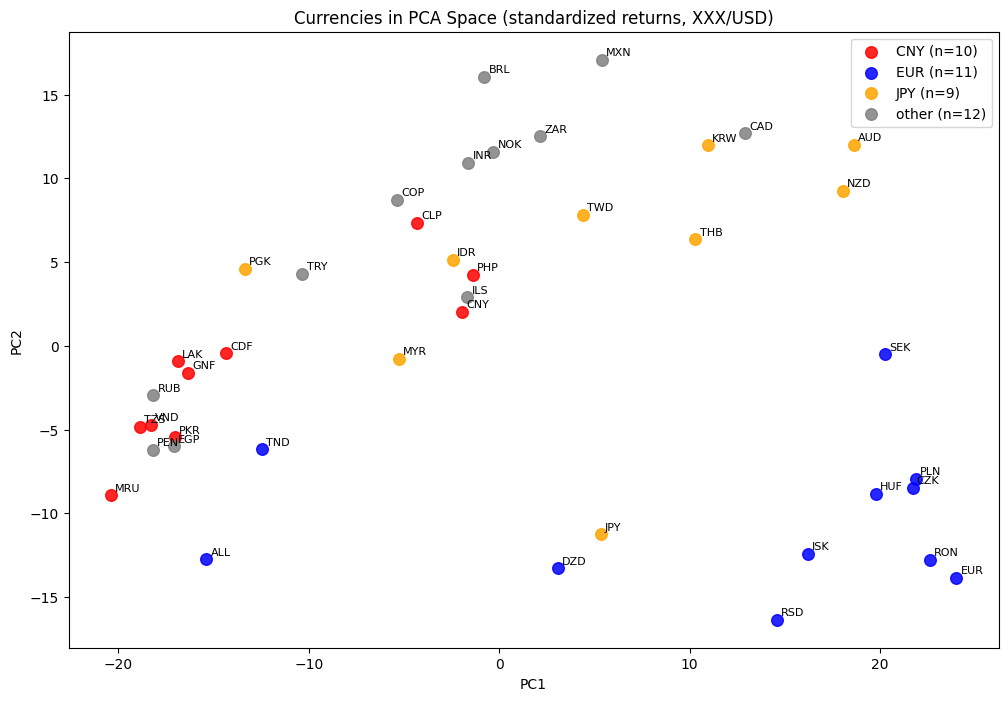

In [22]:
g = {"CNY": ["CDF", "LAK", "TZS", "CLP", "GNF", "PKR", "PHP", "VND", "MRU"],
    "EUR": ["ALL", "CZK", "TND", "RON", "HUF", "PLN", "RSD", "SEK", "ISK", "DZD"],
    "JPY": ["PGK", "TWD", "THB", "AUD", "IDR", "KRW", "MYR", "NZD"],}

def assign(cc):
    for i, j in g.items():
        if cc == i or cc in j:
            return i
    return "other"

pca_df['group'] = pca_df.index.map(assign)

col = {"CNY":"red", "EUR":"blue", "INR":"green", "JPY":"orange", "other":"gray"}

plt.figure(figsize=(12, 8))
for grp, sub in pca_df.groupby("group"):
    plt.scatter(sub["PC1"], sub["PC2"], c=col.get(grp, "black"), s=70, alpha=0.85, label=f"{grp} (n={len(sub)})")
    for i, j in sub.iterrows():
        plt.annotate(i, (j["PC1"], j["PC2"]), xytext=(3,3),textcoords="offset points", fontsize=8)

plt.title("Currencies in PCA Space (standardized returns, XXX/USD)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

#pca_df

In [23]:
#
score = silhouette_score(pca_df[['PC1','PC2']], pca_df['cluster'])
print(score)

0.5532933775232068


In [24]:
lreturn.to_parquet("fx_log_return.parquet", index = False)

In [25]:
results = {}
for i, j in g.items():
    ac = pca_df.loc[i, "cluster"]
    nc = pca_df.loc[j, "cluster"].values
    frac_same = np.mean(nc == ac)
    results[i] = frac_same

print(results)


{'CNY': 0.2222222222222222, 'EUR': 0.8, 'JPY': 0.0}


In [26]:
n = 1000
p = {}

for i, j in g.items():
    ac = pca_df.loc[i, "cluster"]
    nc = pca_df.loc[j, "cluster"].values
    obs = np.mean(nc == ac)
    rs = []
    for k in range(n):
        s = np.random.permutation(pca_df["cluster"].values)
        sac = s[pca_df.index.get_loc(i)]
        snc = [s[pca_df.index.get_loc(n)] for n in j]
        rs.append(np.mean(np.array(snc) == sac))
    pv = np.mean(np.array(rs) >= obs)
    p[i] = (obs, pv)

print(p)

{'CNY': (0.2222222222222222, 0.876), 'EUR': (0.8, 0.001), 'JPY': (0.0, 1.0)}


In [ ]:
# Spencer: Method make sense, validating PC1 PC2 with visuals.

# PHUC's PCA END

In [27]:
yfinance_fx_raw.columns
# Column return Close High Low Open Volume
# think we can just use Close for the time being, could include if in-sufficient

MultiIndex([( 'Close', 'ALL=X'),
            ( 'Close', 'AUD=X'),
            ( 'Close', 'BRL=X'),
            ( 'Close', 'CAD=X'),
            ( 'Close', 'CDF=X'),
            ( 'Close', 'CLP=X'),
            ( 'Close', 'CNY=X'),
            ( 'Close', 'COP=X'),
            ( 'Close', 'CZK=X'),
            ( 'Close', 'DZD=X'),
            ...
            ('Volume', 'RSD=X'),
            ('Volume', 'RUB=X'),
            ('Volume', 'SEK=X'),
            ('Volume', 'THB=X'),
            ('Volume', 'TND=X'),
            ('Volume', 'TRY=X'),
            ('Volume', 'TWD=X'),
            ('Volume', 'TZS=X'),
            ('Volume', 'VND=X'),
            ('Volume', 'ZAR=X')],
           names=['Price', 'Ticker'], length=210)

In [28]:
# px will contain index of daily dates, with close as columns
px = yfinance_fx_raw['Close'].copy()
px

Ticker,ALL=X,AUD=X,BRL=X,CAD=X,CDF=X,CLP=X,CNY=X,COP=X,CZK=X,DZD=X,...,RSD=X,RUB=X,SEK=X,THB=X,TND=X,TRY=X,TWD=X,TZS=X,VND=X,ZAR=X
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-05,122.760002,1.418800,3.9275,1.31670,912.000000,688.599976,6.3461,2960.000000,24.173500,105.360001,...,106.459999,65.991997,8.36390,36.348999,1.9580,2.996300,32.679001,2125.399902,22118.0,13.743380
2015-10-06,121.730003,1.410800,3.9099,1.30830,913.000000,682.599976,6.3461,2903.600098,24.215000,105.680000,...,106.739998,64.772202,8.32310,36.254002,1.9624,2.981920,32.991001,2130.199951,21996.0,13.618480
2015-10-07,121.510002,1.396800,3.8490,1.30440,912.000000,680.400024,6.3461,2898.000000,24.025200,105.389999,...,106.120003,63.391499,8.23406,36.275002,1.9554,2.956000,31.608999,2120.699951,22048.0,13.516830
2015-10-08,121.650002,1.389900,3.8803,1.30651,913.000000,678.799988,6.3461,2868.000000,24.125900,105.347000,...,106.559998,62.250000,8.24320,35.865002,1.9591,2.938000,32.860001,2124.600098,21855.0,13.466930
2015-10-09,121.279999,1.376000,3.7819,1.29985,912.000000,677.000000,6.3435,2843.000000,24.031500,105.217003,...,106.040001,61.307499,8.24093,35.789001,1.9528,2.892870,32.838001,2126.600098,21871.0,13.299180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30,82.250000,1.519300,5.3217,1.39162,2725.000000,964.940002,7.1194,3919.000000,20.699301,129.143005,...,99.345001,83.069458,9.41699,32.209999,2.8965,41.576599,30.458200,2454.985107,26414.0,17.250200
2025-10-01,82.250000,1.512699,5.3195,1.39235,2600.000000,961.260010,7.1190,3924.750000,20.707800,129.175949,...,99.313004,82.892273,9.41662,32.459999,2.8930,41.582699,30.442101,2454.985107,26425.0,17.272671
2025-10-02,82.400002,1.511602,5.3288,1.39395,2600.000000,959.549988,7.1190,3878.760010,20.654800,129.009995,...,99.353996,82.501175,9.37341,32.389999,2.8930,41.594101,30.447001,2454.985107,26405.0,17.206579


In [29]:
#AOA, KPW, MNT, SBD
# as team, we concluded since some of these are un-obtainable, we will drop them from dataset.
px.isna().sum().sort_values()

coverage = px.notna().mean()
#print(coverage)

keep_col = coverage[coverage >= 0.98].index
drop_col = coverage[coverage <= 0.98].index

print(drop_col)
px = px[keep_col]
px.columns


Index(['MRU=X'], dtype='object', name='Ticker')


Index(['ALL=X', 'AUD=X', 'BRL=X', 'CAD=X', 'CDF=X', 'CLP=X', 'CNY=X', 'COP=X',
       'CZK=X', 'DZD=X', 'EGP=X', 'EUR=X', 'GNF=X', 'HUF=X', 'IDR=X', 'ILS=X',
       'INR=X', 'ISK=X', 'JPY=X', 'KRW=X', 'LAK=X', 'MXN=X', 'MYR=X', 'NOK=X',
       'NZD=X', 'PEN=X', 'PGK=X', 'PHP=X', 'PKR=X', 'PLN=X', 'RON=X', 'RSD=X',
       'RUB=X', 'SEK=X', 'THB=X', 'TND=X', 'TRY=X', 'TWD=X', 'TZS=X', 'VND=X',
       'ZAR=X'],
      dtype='object', name='Ticker')

In [30]:
# going to relabel names from XXX=X --> first 3
px.columns = [c.replace('=X','') for c in px.columns]

#aligning to business days
bdays = pd.bdate_range(px.index.min(), px.index.max())
px = px.reindex(bdays).ffill(limit = 3)
px.isna().sum().sort_values()
fx_prices = px.copy()

In [31]:
#log of fx_prices
log_fx_prices = np.log(fx_prices).diff().dropna()
log_fx_prices

,ALL,AUD,BRL,CAD,CDF,CLP,CNY,COP,CZK,DZD,...,RSD,RUB,SEK,THB,TND,TRY,TWD,TZS,VND,ZAR
2015-10-06,-0.008426,-0.005655,-0.004491,-0.006400,0.001096,-0.008752,0.000000,-0.019238,0.001715,0.003033,...,0.002627,-0.018657,-0.004890,-0.002617,0.002245,-0.004811,0.009502,0.002256,-0.005531,-0.009130
2015-10-07,-0.001809,-0.009973,-0.015698,-0.002985,-0.001096,-0.003228,0.000000,-0.001931,-0.007869,-0.002748,...,-0.005825,-0.021547,-0.010756,0.000579,-0.003573,-0.008730,-0.042793,-0.004470,0.002361,-0.007492
2015-10-08,0.001152,-0.004952,0.008099,0.001616,0.001096,-0.002354,0.000000,-0.010406,0.004183,-0.000408,...,0.004138,-0.018171,0.001109,-0.011367,0.001890,-0.006108,0.038814,0.001837,-0.008792,-0.003699
2015-10-09,-0.003046,-0.010051,-0.025686,-0.005111,-0.001096,-0.002655,-0.000410,-0.008755,-0.003920,-0.001235,...,-0.004892,-0.015256,-0.000276,-0.002121,-0.003221,-0.015480,-0.000670,0.000941,0.000732,-0.012535
2015-10-12,-0.006037,-0.006489,-0.006047,-0.003738,0.000000,0.000738,-0.001294,-0.007875,-0.008496,-0.001208,...,-0.009856,0.005774,-0.005357,-0.007657,-0.005031,0.013790,-0.048256,0.000047,0.005699,0.003546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-29,-0.025447,-0.002549,-0.004007,-0.000201,-0.056353,0.000396,-0.000140,-0.000228,-0.005113,0.004910,...,-0.008908,-0.017813,-0.006403,-0.000932,-0.003620,-0.000070,-0.003852,0.000000,0.000190,-0.004695
2025-09-30,0.021201,-0.004260,-0.003855,-0.001580,0.012556,0.005643,-0.001880,0.005024,-0.001796,-0.005197,...,0.002397,0.007297,0.001529,0.000621,-0.002060,0.000373,0.000466,0.000000,0.001099,-0.005215
2025-10-01,0.000000,-0.004354,-0.000414,0.000524,-0.046957,-0.003821,-0.000056,0.001466,0.000411,0.000255,...,-0.000322,-0.002135,-0.000039,0.007732,-0.001209,0.000147,-0.000529,0.000000,0.000416,0.001302
2025-10-02,0.001822,-0.000725,0.001747,0.001148,0.000000,-0.001781,0.000000,-0.011787,-0.002563,-0.001286,...,0.000413,-0.004729,-0.004599,-0.002159,0.000000,0.000274,0.000161,0.000000,-0.000757,-0.003834


In [32]:
# test PCA analysis
# going to scale X with values
# adding a scaler.
scaler = StandardScaler()
X = scaler.fit_transform(log_fx_prices.values)
pca = PCA()
scores = pca.fit_transform(X)
expl_all = pca.explained_variance_ratio_

#print(scores)
#print(expl_all)
#pca.components_

In [33]:
all_currency = pd.DataFrame(
    pca.components_.T,
    index = log_fx_prices.columns,
    columns = [f"PC{i+1}" for i in range(pca.n_components_)]
)

print(np.round(np.cumsum(expl_all[:5]),4))
print(all_currency["PC1"].sort_values(ascending = False))

[0.2286 0.2758 0.3203 0.3517 0.38  ]
EUR    0.285964
CZK    0.278655
PLN    0.277749
RON    0.273741
SEK    0.270371
HUF    0.264325
AUD    0.253421
NZD    0.250292
RSD    0.234660
KRW    0.218199
CAD    0.215683
THB    0.187234
ZAR    0.154757
JPY    0.145059
INR    0.138184
NOK    0.137029
CNY    0.135423
MXN    0.135118
ILS    0.133811
DZD    0.133398
BRL    0.132929
IDR    0.128775
PHP    0.108429
TWD    0.108360
MYR    0.081756
TRY    0.075000
TND    0.053193
PEN    0.048714
TZS    0.036739
PKR    0.036474
ALL    0.016006
ISK    0.014013
COP    0.011978
CLP    0.011848
PGK    0.009767
CDF    0.009518
EGP    0.002967
GNF    0.002194
RUB   -0.002777
LAK   -0.007741
VND   -0.017383
Name: PC1, dtype: float64


In [34]:
# neighbors
# AUD (Australia)
# CAD (Canada)
# CHF (Switzerland)
# SEK (Sweden)
# NOK (Norway)
# MXN (Mexico)
# BRL (Brazil)
# ZAR (South Africa)
# TRY (Turkey)
# CLP (Chile)
# COP (Colombia)
# ILS (Israel)

In [35]:
# Missing some countries from 
anchor_neighbors = {
    "EUR" : ["PLN","HUF","RON","CZK","ISK","ALL","TND","DZD","LYD"],
    "CNY" : ["MNT","MOP","PGK","AOA","AUD","CLP","CDF"],
    "JPY" : ["PHP","BND","PGK"],
    "INR" : ["NPR","BTN","MZN","TZS","BOB","AFN"],
    ""
}

results = {}

for anchor, neigh in anchor_neighbors.items():
    cols_with_anchor = [c for c in [anchor] + neigh if c in log_fx_prices.columns]
    cols_without_anchor = [c for c in neigh if c in log_fx_prices.columns]

    for cols, mode in [(cols_with_anchor, "with_anchor"), (cols_without_anchor, "neightbors_only")]:
        if len(cols) <2:
            continue
        

        X = StandardScaler().fit_transform(log_fx_prices[cols].values)
        pca = PCA()
        X_pca= pca.fit_transform(X)

        expl_var = np.round(np.cumsum(pca.explained_variance_ratio_), 4)
        loading = pd.DataFrame(
        pca.components_.T,
        index = cols,
        columns = [f"PC{i+1}" for i in range(pca.n_components_)]
    )

        print(f"\nAnchor: {anchor} | Mode: {mode}")
        print(expl_var[:5])
        print(loading["PC1"].sort_values(ascending = False))

SyntaxError: ':' expected after dictionary key (1870897663.py, line 7)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=619db6da-a06b-4834-b7df-60521a3a0b3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>